# Object detection with TensorFlow Object Detection API

About a year ago, Google released Coral Dev Board and USB Accelerator which enable deep learning engineers to deploy their models efficiently, fast and offline. The inference is performed directly on the device so there's no need to send the input to the model to a cloud.

The products are not expensive so the technology is accessible even to hobbyists! 

This tutorial series will guide you through the complete process of creating a custom object detector for inference on a Coral product - from setting up the environment to converting the model to an appropriate format for utilizing TPU. Use of the model is not limited to Coral products. If you want to use your model on desktop or Android devices, the process is the same, but you can skip the step where the model is compiled for Edge TPU. 

The code in the tutorial is executed in a Google Colaboratory notebook, but I will mention how to make it work on your local machine. The reason why I've chosen to create the model in Google Colaboratory is that it provides free GPU resources.

The process is broken down into several parts: 
installing TensorFlow Object Detection API
gathering and labelling data
converting the dataset to TFRecord format
configuring the training process
training and evaluating the model
exporting the model to TFLite and compiling it for Edge TPU

The first three points will be covered here and the last three in the next object detection blog post.


## Installation

Firstly, we have to prepare our environment in the Google Colaboratory notebook. COCO API will be used to evaluate our model. It requires NumPy version 1.17.4, otherwise it crashes the training process.

We will also want to visualize losses and mAP metric utilizing Tensorboard. The tensorboard-plugin-wit conflicts with Tensorboard magic so we have to uninstall it.



In [0]:
import numpy as np
import os

if np.__version__ != "1.17.4":
  !pip install numpy==1.17.4 # for cocoapi, otherwise it crashes training
  !pip uninstall tensorboard-plugin-wit # so the tensorboard magic works
  # restarting runtime
  os.kill(os.getpid(), 9)

Let’s now import the needed libraries. TensorFlow Object Detection API works for TensorFlow 1.x (>= 1.12) so the TensorFlow magic ensures that the right version is imported. 


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

### Connect to Google Drive account (copy the authorization code).

One of the perks of using Google Colaboratory is easily accessing your Google Drive. 
If you want to connect your Drive, running the next cell will prompt you to authorize your account.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Install TensorFlow Object Detection API

Now we need to clone the tensorflow/models repository and install libraries it depends on. 


In [0]:
DEST_DIR = '/content/object_detection_demo'
os.mkdir(DEST_DIR)

In [0]:
%cd '/content/object_detection_demo'
!pip install tf_slim
!git clone --quiet https://github.com/tensorflow/models.git
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib

/content/object_detection_demo
     |████████████████████████████████| 358kB 4.8MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5

The TensorFlow Object Detection API uses Protobufs to configure model and training parameters. Next cell compiles the Protobuf libraries. 

In [0]:
%cd '/content/object_detection_demo/models/research'
!protoc object_detection/protos/*.proto --python_out=.

/content/object_detection_demo/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


The API depends on the TensorFlow Slim so we need to add the tensorflow/models/research/ and slim directories to PYTHONPATH.

In [0]:
%cd /content/object_detection_demo/models/research
os.environ['PYTHONPATH'] += ':/:slim/'

/content/object_detection_demo/models/research


#### Build and verify the installation

Test that you have correctly installed the TensorFlow Object Detection by executing the following cell. The final output should be something like "OK (skipped=1)". If you get an error concerning `tensorflow.contrib`, factory reset and try again from the beginning.


In [0]:
!python setup.py install
!python object_detection/builders/model_builder_tf1_test.py

running install
running bdist_egg
running egg_info
creating object_detection.egg-info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/model_lib.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/model_lib_test.py -> build/lib/object_detection
copying obj

#### COCO API

Lastly, in order to use COCO evaluation metrics we need to install the COCO API and copy the pycocotools subfolder to the tensorflow/models/research directory.

In [0]:
%cd '/content'
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools \
/content/object_detection_demo/models/research/

/content
Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (575/575), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist

## Data

I’ve decided to try to train a detector which detects human faces which are wearing a mask, not wearing a mask or not wearing it properly. The Medical Masks Dataset is available for download [here](https://www.kaggle.com/vtech6/medical-masks-dataset) if you have a Kaggle account.


The dataset contains two subfolders - `images` and `labels`. I uploaded the dataset to my drive and loaded it into the notebook with the following code:


In [0]:
dataset_name = "kaggle-medical-masks-dataset"
data_dir = "/content/object_detection_demo/data"
os.mkdir(data_dir)
os.mkdir(os.path.join(data_dir, dataset_name))

In [0]:
%cd {data_dir}/{dataset_name}
!unzip -qq /content/gdrive/My\ Drive/{dataset_name}.zip

/content/object_detection_demo/data/kaggle-medical-masks-dataset


In [0]:
!mv {data_dir}/{dataset_name}/labels/* {data_dir}/{dataset_name}/images/
!rm -rf {data_dir}/{dataset_name}/labels/

### Visualization

There are three classes in the dataset: 
  - `good` (the person is wearing a mask correctly),
  - `bad` (the person is not wearing a mask),
  - `none` (the person is wearing a mask, but incorrectly).

In [0]:
!pip install xmltodict

In [0]:
import xmltodict

# credits to https://www.kaggle.com/dohunkim/visualizing-medical-mask-dataset for the code

def parse_xml(label_path):
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


def visualize_image(image_path, label_path, bndbox=True):
    image_name = image_path.split("/")[-1]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'bad':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [0]:
import cv2
import random

def plotExamples(src, n = 10):
  """ 
  Plots n samples from src containing all three classes.
  Assumes the XML annotation filesa are in Pascal VOC format.
  """
  
  img_files = os.listdir(src)
  img_files = [filename for filename in img_files if not filename.endswith(".xml")]

  cnt = 0
  for filename in img_files:
    image_path = os.path.join(src, filename)
    label_path = ".".join(image_path.split(".")[:-1]) + ".xml"

    labels, size = parse_xml(label_path)
    classes = set([name for (name, bndbox) in labels])
    if len(classes) == 3:
      visualize_image(image_path, label_path)
      cnt += 1

    if cnt > n:
      break

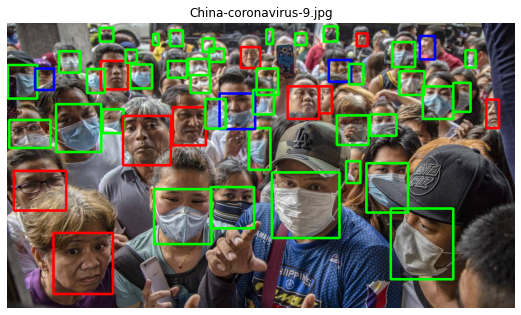

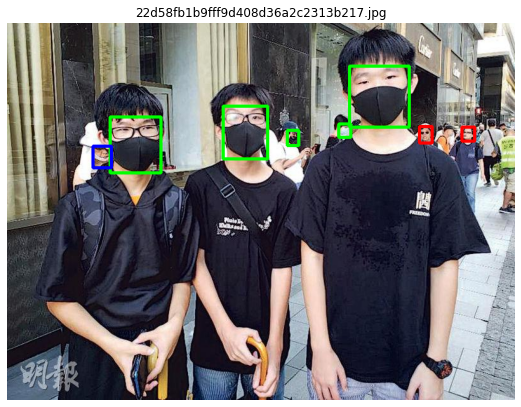

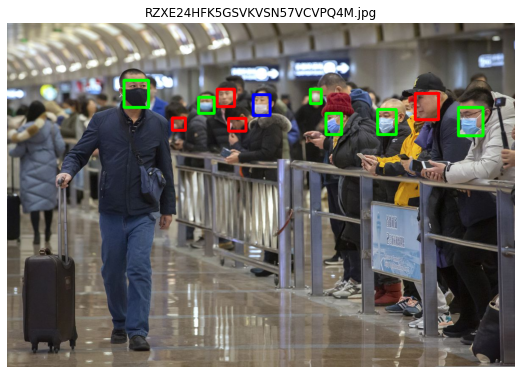

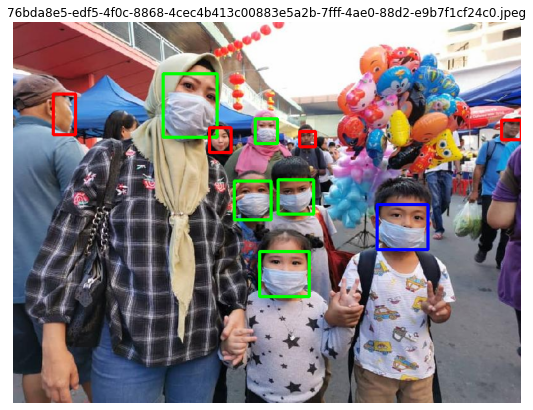

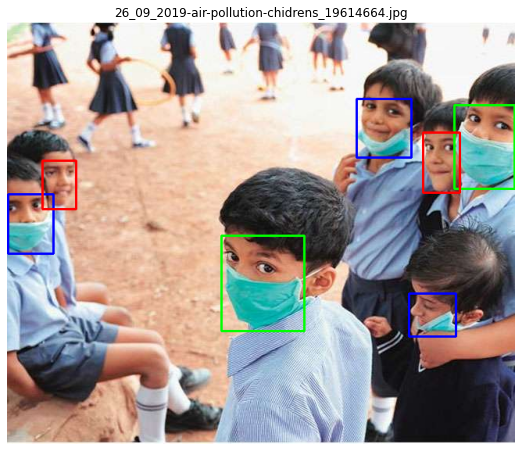

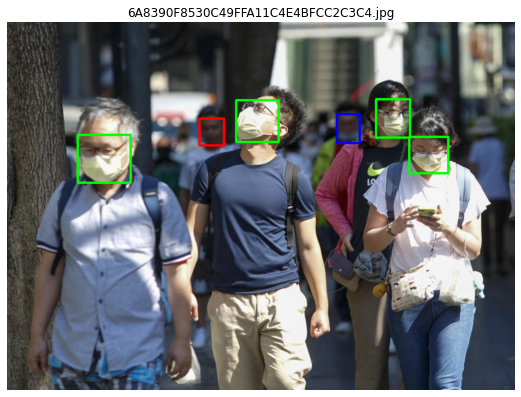

In [0]:
plotExamples(src="{}/{}/images".format(data_dir, dataset_name), n=5)

In [0]:
import cv2
import random

def plotDataSamples(src, n = 10):
  """ 
  Plots n randomly selected samples from src.
  Assumes the XML annotation filesa are in Pascal VOC format.
  """
  
  img_files = os.listdir(src)
  img_files = [filename for filename in img_files if not filename.endswith(".xml")]
  indices = [random.randint(0,len(img_files)) for _ in range(0,n)]
  img_files = [img_files[ind] for ind in indices]

  cnt = 0
  for filename in img_files:
    image_path = os.path.join(src, filename)
    label_path = ".".join(image_path.split(".")[:-1]) + ".xml"

    visualize_image(image_path, label_path)

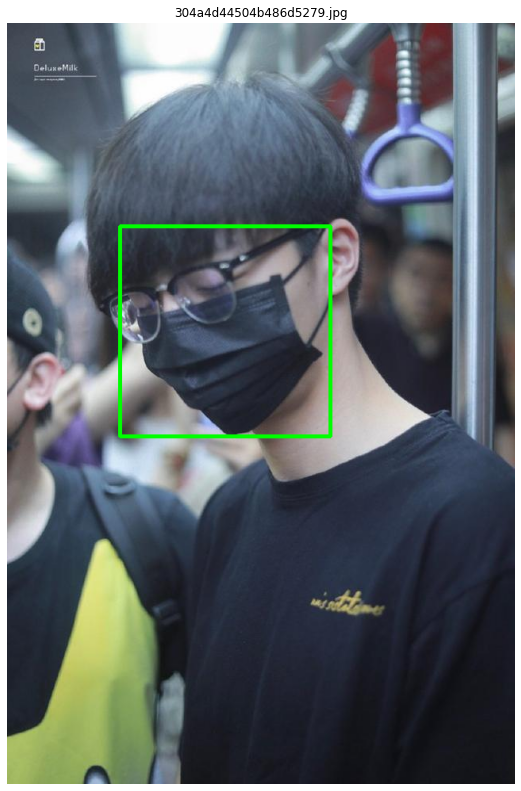

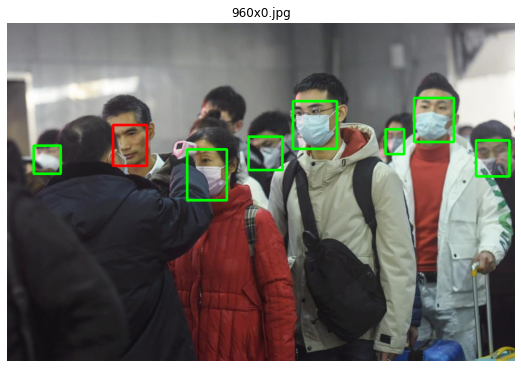

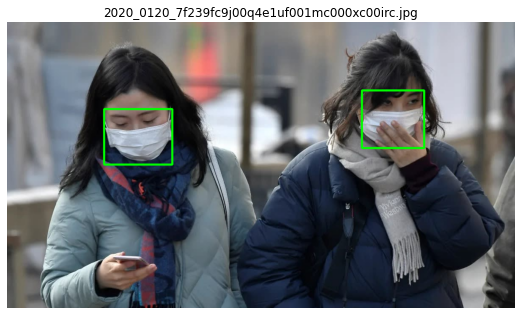

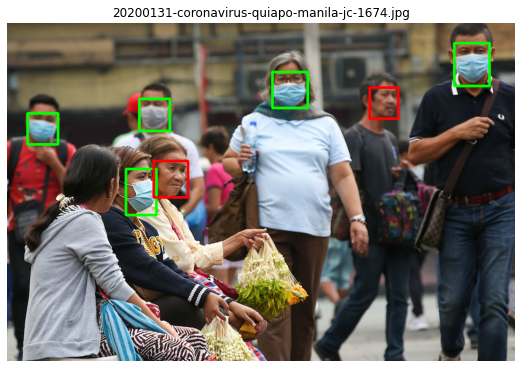

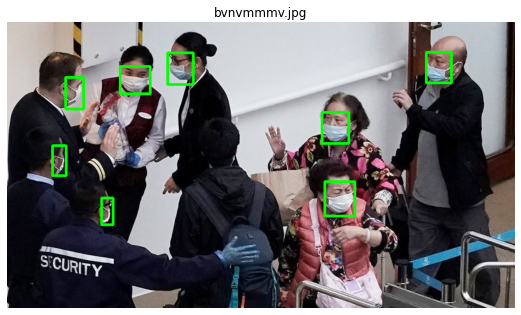

In [0]:
plotDataSamples(src="{}/{}/images".format(data_dir, dataset_name), n=5)

In [0]:
# explore class distribution
from collections import Counter

src = "{}/{}/images".format(data_dir, dataset_name)

img_files = os.listdir(src)
img_files = [filename for filename in img_files if not filename.endswith(".xml")]

class_names = []

for filename in img_files:
  image_path = os.path.join(src, filename)
  label_path = ".".join(image_path.split(".")[:-1]) + ".xml"

  labels, size = parse_xml(label_path)
  class_names += [name for (name, bndbox) in labels]

cnt = Counter(class_names)
cnt

Counter({'bad': 667, 'good': 3121, 'none': 126})

In the dataset there are 3121 ‘good’ examples, 667 ‘bad’ and 126 ‘none’. Observe that the data is class imbalanced. You could use sampling methods or even generative adversarial networks to deal with this issue, but I won’t do that in this tutorial.


<BarContainer object of 3 artists>

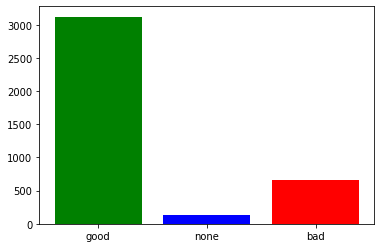

In [0]:
plt.bar(cnt.keys(), cnt.values(), color=['green', 'blue', 'red'])

### Split data into training and test set

Currently, images folder contains images and XML files. The images and their labels in the corresponding XML files will be converted into an appropriate format which will be finally used for model training. Those files will be stored in annotations.

I must first split the dataset into training and test sets. Each set will contain images and their XML files. 


In [0]:
import random
import shutil

os.mkdir('{0}/{1}/images/train'.format(data_dir, dataset_name))
os.mkdir('{0}/{1}/images/test'.format(data_dir, dataset_name))

src = '{0}/{1}/images'.format(data_dir, dataset_name)
files = os.listdir(src)
img_files = [filename for filename in files if not \
filename.endswith('.xml') and not os.path.isdir(os.path.join(src, filename))]

random.seed(42)
random.shuffle(img_files)

n_train = 0.8
n_test = 1.0 - n_train

train_examples = img_files[:int(n_train*len(img_files))]
test_examples = img_files[int(n_train*len(img_files)):]

print("Training files: ", len(train_examples))
print("Testing files: ", len(test_examples))

Training files:  542
Testing files:  136


Move the training examples to `train` folder.

In [0]:
dst = src + "/" + "train"
for filename in train_examples:
  xml_name = ".".join(filename.split(".")[:-1]) + ".xml"
  if os.path.isfile('{0}/{1}'.format(src, xml_name)):
    shutil.move('{0}/{1}'.format(src, filename), dst)
    shutil.move('{0}/{1}'.format(src, xml_name), dst)

Move the testing examples to `test` folder.

In [0]:
dst = src + "/" + "test"
for filename in test_examples:
  xml_name = ".".join(filename.split(".")[:-1]) + ".xml"
  if os.path.isfile('{0}/{1}'.format(src, xml_name)):
    shutil.move('{0}/{1}'.format(src, filename), dst)
    shutil.move('{0}/{1}'.format(src, xml_name), dst)

Some XML files will end up unmatched because they don’t have an image pair. We’ll delete those.

In [0]:
unmatched = os.listdir(src)
for filename in unmatched:
  full_path = os.path.join(src, filename)
  if not os.path.isdir(full_path):
    os.remove(full_path)

### TFRecords

TFRecord is TensorFlow’s binary storage format for reading (training) data efficiently. Although it’s very convenient, the lack of documentation on this format and how to write/read it is discouraging. Fortunately, someone already did all the hard work. For data conversion we only need two scripts: [xml_to_csv.py](https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py) and [generate_tf_record.py](https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py). The first one converts XML files to .csv files where each row is a single object example containing its bounding box coordinates, class name and image’s shape. The second script reads a .csv file and stores the data in the TFRecord format. The bounding box coordinates are normalized to range [0,1] before storing. 

The second cell downloads the scripts from my GitHub repository. I altered generate_tf_record.py because width and height values in some annotations are zero. I fix that by reading the image and getting its shape. 


In [0]:
%cd '/content/object_detection_demo'
!wget https://raw.githubusercontent.com/drajsel/object_detection_tutorial/master/my_generate_tfrecord.py .
!wget https://raw.githubusercontent.com/drajsel/object_detection_tutorial/master/xml_to_csv.py .

/content/object_detection_demo
--2020-06-04 09:55:55--  https://raw.githubusercontent.com/drajsel/object_detection_tutorial/master/my_generate_tfrecord.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5325 (5.2K) [text/plain]
Saving to: ‘my_generate_tfrecord.py’

my_generate_tfrecor 100%[===================>]   5.20K  --.-KB/s    in 0s      

2020-06-04 09:55:55 (58.5 MB/s) - ‘my_generate_tfrecord.py’ saved [5325/5325]

--2020-06-04 09:55:55--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-06-04 09:55:55--
Total wall clock time: 0.2s
Downloaded: 1 files, 5.2K in 0s (58.5 MB/s)
--2020-06-04 09:55:57--  https://raw.githubusercontent.com/drajsel/object_detection_tutorial/master/xm

In [0]:
os.mkdir("{}/{}/annotations".format(data_dir, dataset_name))

Convert the annotations in XML format to csv files (one for `train`, one for `test` folder).


In [0]:
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py \
-i {data_dir}/{dataset_name}/images/train \
-o {data_dir}/{dataset_name}/annotations/train_labels.csv \
-l {data_dir}/{dataset_name}/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py \
-i {data_dir}/{dataset_name}/images/test \
-o {data_dir}/{dataset_name}/annotations/test_labels.csv


Successfully converted xml to csv.
Generate `/content/object_detection_demo/data/kaggle-medical-masks-dataset/annotations/label_map.pbtxt`
Successfully converted xml to csv.


Next, generate TFRecords from the csv files. 


In [0]:
# Generate `train.record`
!python my_generate_tfrecord.py \
--csv_input={data_dir}/{dataset_name}/annotations/train_labels.csv \
--output_path={data_dir}/{dataset_name}/annotations/train.record \
--img_path={data_dir}/{dataset_name}/images/train \
--label_map {data_dir}/{dataset_name}/annotations/label_map.pbtxt

# Generate `test.record`
!python my_generate_tfrecord.py \
--csv_input={data_dir}/{dataset_name}/annotations/test_labels.csv \
--output_path={data_dir}/{dataset_name}/annotations/test.record \
--img_path={data_dir}/{dataset_name}/images/test \
--label_map {data_dir}/{dataset_name}/annotations/label_map.pbtxt



W0604 09:57:46.817066 140583990097792 module_wrapper.py:139] From my_generate_tfrecord.py:122: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 09:57:47.039961 140583990097792 module_wrapper.py:139] From my_generate_tfrecord.py:55: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/kaggle-medical-masks-dataset/annotations/train.record


W0604 09:57:51.748928 140584461744000 module_wrapper.py:139] From my_generate_tfrecord.py:122: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 09:57:51.805579 140584461744000 module_wrapper.py:139] From my_generate_tfrecord.py:55: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/kaggle-medical-masks-dataset/annotations/test.record


TensorFlow also requires a label map, which maps each of the used labels to integer values. It’s used both by the training and inference processes. 


In [0]:
%cd '/content/object_detection_demo/models/research'
from object_detection.utils import label_map_util

label_map = \
label_map_util.load_labelmap('{0}/{1}/annotations/label_map.pbtxt' \
  .format(data_dir, dataset_name))
categories = label_map_util.convert_label_map_to_categories(
label_map, max_num_classes=90, use_display_name=True
)

test_record_fname = \
'{0}/{1}/annotations/test.record'.format(data_dir, dataset_name)
train_record_fname = \
'{0}/{1}/annotations/train.record'.format(data_dir, dataset_name)
label_map_pbtxt_fname = \
'{0}/{1}/annotations/label_map.pbtxt'.format(data_dir, dataset_name)

/content/object_detection_demo/models/research


In the next part we’ll start with configuring the training process and by the end of the article we’ll have a working medical mask detector!